In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from skimage import io
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

### 0. Creación de conjunto de entrenamiento y prueba


In [2]:
RUTA_ENTRENAMIENTO = '/home/jorge/Documents/Blog/Pokemon_Classifier/data/scaled/train' 
RUTA_PRUEBA = '/home/jorge/Documents/Blog/Pokemon_Classifier/data/scaled/test'

In [3]:
data_entrenamiento = datasets.ImageFolder(RUTA_ENTRENAMIENTO)
data_prueba = datasets.ImageFolder(RUTA_PRUEBA)

In [4]:
len(data_entrenamiento), len(data_prueba)

(2194, 550)

Clase: 0


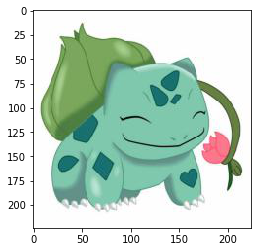

In [5]:
img, clase = data_entrenamiento[0]
print(f'Clase: {clase}')
plt.imshow(img)
plt.show()

In [6]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]
transformaciones = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=MEAN, std=STD)])

data_entrenamiento = datasets.ImageFolder(RUTA_ENTRENAMIENTO,
                                          transform=transformaciones)
data_prueba = datasets.ImageFolder(RUTA_PRUEBA,
                                   transform=transformaciones)

### 1. Crear Generadores de datos

In [7]:
generador_entrenamiento = DataLoader(data_entrenamiento,
                                     batch_size=10,
                                     shuffle=True,
                                     num_workers=4)
generador_prueba = DataLoader(data_entrenamiento,
                              batch_size=10,
                              shuffle=True,
                              num_workers=4)

In [8]:
img, clase = next(iter(generador_entrenamiento))

In [9]:
img.shape, clase.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

### 2. Cargar Modelo

In [10]:
modelo = models.mobilenet_v2(pretrained=True, progress=True)

In [11]:
summary(modelo, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [12]:
modelo

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_

In [13]:
modelo.classifier

Sequential(
  (0): Dropout(p=0.2)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [14]:
modelo.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(1_280, 6))

In [15]:
modelo.classifier[1] = nn.Linear(1280, 6, bias=True)

In [16]:
summary(modelo, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### 3. Crear Función de Entrenamiento

In [32]:
class Entrenador:
    
    def __init__(self, data, modelo, optimizador, funcion_costo):
        self.data = data
        self.modelo = modelo
        self.optimizador = optimizador
        self.funcion_costo = funcion_costo
    
    def entrena(self):
        self.modelo.train()
        
        costo = 0
        for img, clase in self.data:
            self.optimizador.zero_grad()
            salida = self.modelo(img)
            _, prediccion = torch.max(salida, dim=1)
            perdida = self.funcion_costo(salida, clase)
            perdida.backward()
            self.optimizador.step()
            costo += perdida.item()
        return costo / len(self.data), 0
            
class Evaluador:
    
    def __init__(self):
        pass
    
    def evalua(self):
        pass

### 4. Entrenar Modelo

In [33]:
epocas = 10
optimizador = torch.optim.Adam(modelo.parameters())
funcion_costo = nn.CrossEntropyLoss(reduction='sum')

In [34]:
entrenador = Entrenador(generador_entrenamiento, modelo,
                        optimizador, funcion_costo)
for epoca in range(1, epocas + 1):
    print(f'Procesando epoca: {epoca}/{epocas}', end='\n\t')
    costo_entrenamiento, precision_entrenamiento = entrenador.entrena()
    #costo_prueba, precision_prueba = evaluador.evalua()
    print(f'Costo Entrenamiento: {costo_entrenamiento}', end='\n\t')
    print(f'Precision Entrenamiento: {precision_entrenamiento}')
    #print(f'Costo Prueba: {costo_prueba}', end='\n\t')
    #print(f'Precision Prueba: {precision_prueba}')
    print('*****' * 10)

Procesando epoca: 1/10
	Costo Entrenamiento: 4.455581367286769
	Precision Entrenamiento: 0
*************************
Procesando epoca: 2/10
	Costo Entrenamiento: 3.280315265872262
	Precision Entrenamiento: 0
*************************
Procesando epoca: 3/10
	Costo Entrenamiento: 2.506451773914424
	Precision Entrenamiento: 0
*************************
Procesando epoca: 4/10
	Costo Entrenamiento: 2.298360915211114
	Precision Entrenamiento: 0
*************************
Procesando epoca: 5/10
	Costo Entrenamiento: 2.158409205756404
	Precision Entrenamiento: 0
*************************
Procesando epoca: 6/10
	Costo Entrenamiento: 1.423689405484633
	Precision Entrenamiento: 0
*************************
Procesando epoca: 7/10
	Costo Entrenamiento: 1.8285268067636273
	Precision Entrenamiento: 0
*************************
Procesando epoca: 8/10
	Costo Entrenamiento: 1.1128832687031138
	Precision Entrenamiento: 0
*************************
Procesando epoca: 9/10
	Costo Entrenamiento: 1.40539285865697
